In [27]:
# Numerical Operations
import math
import numpy as np
import random
from pyDOE import lhs
import time

# Reading/Writing Data
import pandas as pd
import os
import scipy.io

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Post
import matplotlib.pyplot as plt

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [29]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

same_seed(6666)

In [30]:
import torch.nn as nn
import torch.nn.init as init
from collections import OrderedDict

class My_Model(nn.Module):
    def __init__(self, layers):
        
        super(My_Model, self).__init__()

        self.depth = len(layers) - 1 
        self.activation = nn.Tanh()

        layer_list = []
        for i in range(self.depth-1):
            layer_list.append(('layer_%d' % i, nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation))
        layer_list.append(('layer_%d' % (self.depth-1), nn.Linear(layers[-2], layers[-1])))

        self.layers = torch.nn.Sequential(OrderedDict(layer_list))
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)  # 或者使用 init.xavier_normal_
                if layer.bias is not None:
                    init.zeros_(layer.bias)  # 可选，初始化偏置为0

    def forward(self, x):
        x = self.layers(x)
        #x = x.squeeze(1)  # (B, 1) -> (B)
        return x

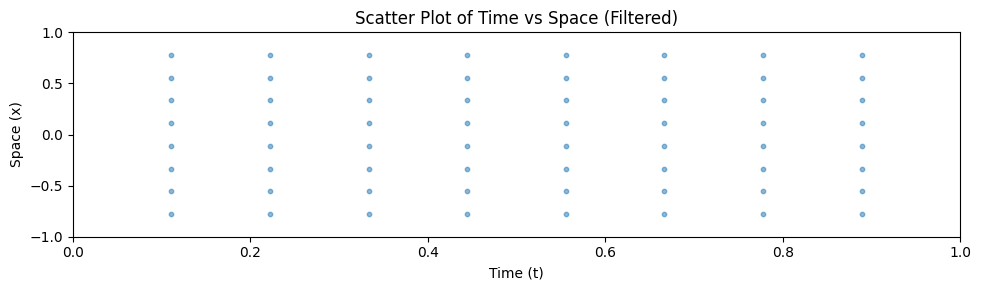

(64, 2)


In [31]:
# x: -1.0 -> 1.0
# t: 0.0 -> 1.0

# 生成随机点
#num_points = 1000
#lhs_points = lhs(2, num_points)  # 生成拉丁超立方体样本
#XT = np.array([-1.0, 0.0]) + np.array([2.0, 1.0]) * lhs_points  # 转换到目标范围

# 定义参数
num_t_points = 10  # t 的点数
num_x_points = 10  # x 的点数

# 生成均匀分布的网格点
x = np.linspace(-1.0, 1.0, num_x_points)  # 在 [-1, 1] 范围内生成 40 个点
t = np.linspace(0.0, 1.0, num_t_points)    # 在 [0, 1] 范围内生成 20 个点

# 创建网格
X, T = np.meshgrid(x, t)

# 将网格展平为二维数组
XT = np.vstack([X.ravel(), T.ravel()]).T

# 去除边界点
XT = XT[(XT[:, 0] > -1) & (XT[:, 0] < 1) & (XT[:, 1] > 0) & (XT[:, 1] < 1)]

# 提取时间和空间坐标
x = XT[:, 0]  # 纵坐标（空间）
t = XT[:, 1]  # 横坐标（时间）

# 创建图形
plt.figure(figsize=(10, 3))  # 设置图形大小
plt.scatter(t, x, s=10, alpha=0.5)  # 绘制散点图
plt.title('Scatter Plot of Time vs Space (Filtered)')
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')

plt.xlim(0.0, 1.0)
plt.ylim(-1.0, 1.0)

# 显示图形
plt.tight_layout()  # 自动调整子图参数
plt.show()

print(XT.shape)  # 打印过滤后的形状

In [32]:
# 生成 INLET 网格点
ini_points = 10
x_inlet = np.linspace(-1.0, 1.0, ini_points)  # x 从 -1 到 1
t_inlet = np.zeros_like(x_inlet)               # t = 0
INLET = np.vstack([x_inlet, t_inlet]).T

u_0 = -np.sin(math.pi * INLET[:, 0])  

# 生成 WALL_up 网格点
wallup_points = 10
x_wall_up = np.ones(wallup_points)              # x = 1
t_wall_up = np.linspace(0.0, 1.0, wallup_points)  # t 从 0 到 1
WALL_up = np.vstack([x_wall_up, t_wall_up]).T

# 生成 WALL_down 网格点
walldown_points = 10
x_wall_down = -np.ones(walldown_points)            # x = -1
t_wall_down = np.linspace(0.0, 1.0, walldown_points)  # t 从 0 到 1
WALL_down = np.vstack([x_wall_down, t_wall_down]).T

print(INLET.shape)
print(u_0.shape)
print(WALL_up.shape)
print(WALL_down.shape)

(10, 2)
(10,)
(10, 2)
(10, 2)


In [33]:
'''
ini_points = 100
lhs_points_ini = lhs(2, ini_points)  # 生成拉丁超立方体样本
INLET = np.array([-1.0, 0.0]) + np.array([2.0, 0.0]) * lhs_points_ini  # 转换到目标范围
u_0 = -np.sin(math.pi * INLET[:, 0])  

wallup_points = 40
lhs_points_wallup = lhs(2, wallup_points)
WALL_up = np.array([1.0, 0.0]) + np.array([0.0, 1.0]) * lhs_points_wallup

walldown_points = 40
lhs_points_walldown = lhs(2, walldown_points)
WALL_down = np.array([-1.0, 0.0]) + np.array([0.0, 1.0]) * lhs_points_walldown
'''

'\nini_points = 100\nlhs_points_ini = lhs(2, ini_points)  # 生成拉丁超立方体样本\nINLET = np.array([-1.0, 0.0]) + np.array([2.0, 0.0]) * lhs_points_ini  # 转换到目标范围\nu_0 = -np.sin(math.pi * INLET[:, 0])  \n\nwallup_points = 40\nlhs_points_wallup = lhs(2, wallup_points)\nWALL_up = np.array([1.0, 0.0]) + np.array([0.0, 1.0]) * lhs_points_wallup\n\nwalldown_points = 40\nlhs_points_walldown = lhs(2, walldown_points)\nWALL_down = np.array([-1.0, 0.0]) + np.array([0.0, 1.0]) * lhs_points_walldown\n'

In [34]:
def pde_loss(XT, model, device):

    XT = torch.tensor(XT, dtype=torch.float32, requires_grad=True).to(device)

    u = model(XT)
    #u = output_pde[:, 0]

    u_XT = torch.autograd.grad(u, XT, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = u_XT[:, 0]
    u_t = u_XT[:, 1]

    u_xx = torch.autograd.grad(u_XT, XT, torch.ones_like(u_XT), retain_graph=True, create_graph=True)[0][:, 0]

    loss = torch.mean((u_t + u*u_x - 0.01 / math.pi * u_xx)**2)
    return loss

def boundary_loss(INLET, WALL_up, WALL_down, u_0, model, device):
    
    INLET = torch.tensor(INLET, dtype=torch.float32, requires_grad=True).to(device)
    WALL_up = torch.tensor(WALL_up, dtype=torch.float32, requires_grad=True).to(device)
    WALL_down = torch.tensor(WALL_down, dtype=torch.float32, requires_grad=True).to(device)
    u_0 = torch.tensor(u_0, dtype=torch.float32, requires_grad=True).to(device)

    u_in = model(INLET)
    #print(u_in)
    u_up = model(WALL_up)
    u_d = model(WALL_down)

    loss_inlet = torch.mean((u_in - u_0)**2)
    #print(u_in + u_0)
    loss_up = torch.mean(u_up**2)
    loss_down = torch.mean(u_d**2)

    total_loss = loss_up + loss_down + loss_inlet

    return total_loss

In [35]:
loss_pde1 = []
loss_bd_ic1 = []

def train(model, device):

    if not os.path.isdir('./models'):
        os.mkdir('./models')

    optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)

    n_epochs, best_loss, early_stop_count = 1000, math.inf, 0

    for epoch in range(n_epochs):
        optimizer_adam.zero_grad()

        loss_pde = pde_loss(XT, model, device)
        loss_bd_ic = boundary_loss(INLET, WALL_up, WALL_down, u_0, model, device)
        loss = loss_pde + loss_bd_ic
        loss.backward()
        optimizer_adam.step()

        loss_pde1.append(loss_pde.detach().item())
        loss_bd_ic1.append(loss_bd_ic.detach().item())

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {(loss_pde1[-1]+loss_bd_ic1[-1]):.10f}, loss_pde: {loss_pde1[-1]:.10f}, loss_bd_ic:{loss_bd_ic1[-1]:.10f}') 
            print('Saving model with loss {:.10f}...'.format(best_loss))
            
        if (loss_pde1[-1]+loss_bd_ic1[-1]) < best_loss:
            best_loss = (loss_pde1[-1]+loss_bd_ic1[-1])
            torch.save(model.state_dict(), './models/model.ckpt') # Save your best model
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= 500: 
            print('\nModel is not improving, so we halt the training session.')
            break

In [36]:
model = My_Model([2] + 4 * [20] + [1]).to(device)
train(model, device)     # 

Epoch [100/1000]: Train loss: 0.4502468946, loss_pde: 0.0001485291, loss_bd_ic:0.4500983655
Saving model with loss 0.4502514120...
Epoch [200/1000]: Train loss: 0.4500821879, loss_pde: 0.0000304927, loss_bd_ic:0.4500516951
Saving model with loss 0.4500828596...
Epoch [300/1000]: Train loss: 0.4500505485, loss_pde: 0.0000128604, loss_bd_ic:0.4500376880
Saving model with loss 0.4500507266...
Epoch [400/1000]: Train loss: 0.4500394413, loss_pde: 0.0000096211, loss_bd_ic:0.4500298202
Saving model with loss 0.4500395487...
Epoch [500/1000]: Train loss: 0.4500323252, loss_pde: 0.0000083760, loss_bd_ic:0.4500239491
Saving model with loss 0.4500324236...
Epoch [600/1000]: Train loss: 0.4500268671, loss_pde: 0.0000076267, loss_bd_ic:0.4500192404
Saving model with loss 0.4500269334...
Epoch [700/1000]: Train loss: 0.4500223573, loss_pde: 0.0000069912, loss_bd_ic:0.4500153661
Saving model with loss 0.4500223933...
Epoch [800/1000]: Train loss: 0.4500185845, loss_pde: 0.0000063774, loss_bd_ic:0.45

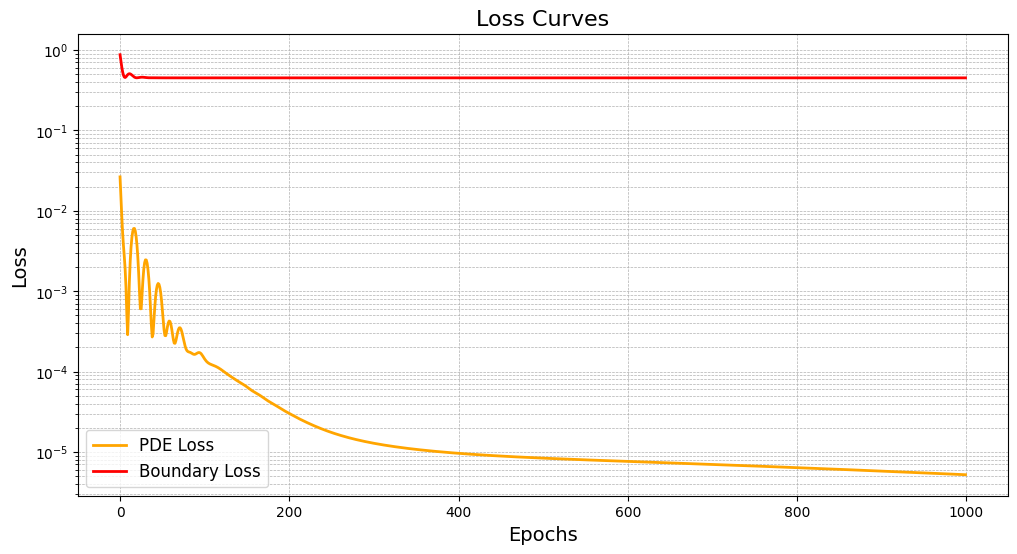

In [37]:
def plot_loss_curves(loss_pde_record, loss_bd_record, save_path='loss_curves.png'):
    plt.figure(figsize=(12, 6))

    # 计算 epoch 范围
    epochs = range(len(loss_pde_record))

    # 绘制各个损失曲线
    #plt.plot(epochs, loss_pde_record + loss_bd_record, label='Total Loss', color='blue', linewidth=2)
    plt.plot(epochs, loss_pde_record, label='PDE Loss', color='orange', linewidth=2)
    plt.plot(epochs, loss_bd_record, label='Boundary Loss', color='red', linewidth=2)

    # 添加标题和标签
    plt.title('Loss Curves', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    
    # 设置 y 轴的对数刻度（可选）
    plt.yscale('log')

    # 添加网格
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    # 添加图例
    plt.legend(fontsize=12)

    # 保存图像到指定路径
    #plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_loss_curves(loss_pde1, loss_bd_ic1)

In [38]:
model = My_Model([2] + 4 * [20] + [1]).to(device)
model.load_state_dict(torch.load('models\model.ckpt'))

C:\Users\FAVE\AppData\Local\Temp\ipykernel_28176\2145766366.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models\model.ckpt'))


<All keys matched successfully>

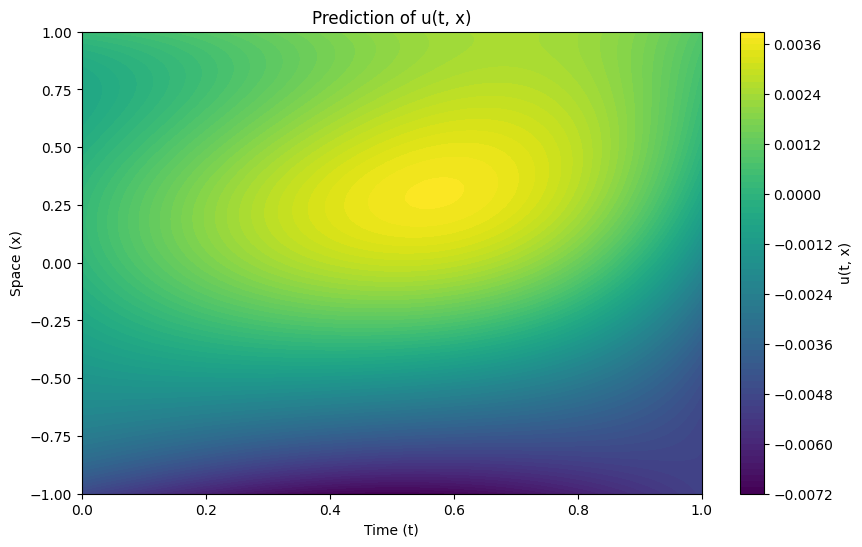

In [39]:
# 生成 x 和 t 的网格
x_values = np.linspace(-1, 1, 100)
t_values = np.linspace(0, 1, 100)
T, X = np.meshgrid(t_values, x_values)  # 交换 X 和 T

# 将网格数据转换为张量并移动到设备
inputs = torch.tensor(np.vstack([T.flatten(), X.flatten()]).T, dtype=torch.float32).to(device)

# 使用模型进行预测
with torch.no_grad():  # 关闭梯度计算
    U = model(inputs).cpu().numpy()  # 预测后将结果移回 CPU，以便使用 NumPy

# 重新调整 U 的形状以匹配 T 和 X
U = U.reshape(T.shape)

# 绘制图形
plt.figure(figsize=(10, 6))
contour = plt.contourf(T, X, U, levels=100, cmap='viridis')  # 使用viridis色图
plt.colorbar(contour, label='u(t, x)')  # 添加颜色条

# 添加标签和标题
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.title('Prediction of u(t, x)')

# 显示图形
plt.show()